# Data Exploration and PreProcessing Notebook
Welcome to the Data Exploration and Preprocessing Notebook for our project, delivered in Part 1 of our data science endeavor. This Jupyter notebook serves as a comprehensive guide detailing the exploration and preprocessing steps applied to the raw data. Our objective is to provide insight into the initial stages of our data analysis pipeline, including data cleansing, feature engineering, and any transformations performed on the dataset.

In this notebook, we will embark on a journey to uncover the intricacies of our dataset, understand its structure, identify potential issues, and prepare it for further analysis. By meticulously exploring and preprocessing the data, we aim to lay a solid foundation for subsequent stages of our project, enabling us to derive meaningful insights and build robust machine learning models.

## Each feature provides valuable insights into the health profile of individuals. Here's a quick overview of the key features:

- **HeartDisease:** Indicates the presence (1) or absence (0) of heart disease.
- **Smoking:** Reflects smoking habits (1 for Yes, 0 for No).
- **AlcoholDrinking:** Captures alcohol consumption habits (1 for Yes, 0 for No).
- **Stroke:** Indicates whether an individual had a stroke (1 for Yes, 0 for No).
- **DiffWalking:** Reflects difficulty walking (1 for Yes, 0 for No).
- **Sex:** Represents gender (1 for Male, 0 for Female).
- **AgeCategory:** Categorizes age into groups, such as 18-24, 25-29, ..., 80 or older.
- **Race:** Classifies individuals into different racial categories (e.g., White, Black, Hispanic).
- **Diabetic:** Indicates diabetic status (0 for No, 1 for Yes).
- **PhysicalActivity:** Reflects engagement in physical activity (1 for Yes, 0 for No).
- **GenHealth:** Rates general health on a scale from Excellent (1) to Poor (5).
- **Asthma:** Indicates asthma status (1 for Yes, 0 for No).
- **KidneyDisease:** Reflects the presence (1) or absence (0) of kidney disease.
- **SkinCancer:** Indicates whether an individual has skin cancer (1 for Yes, 0 for No).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from scipy.stats import ttest_ind, probplot, shapiro
import statsmodels.stats.api as sms

In [2]:
class DataLoader:

    def __init__(self, filename, target):
        """
        Initializes the DataLoader with the filename of the dataset,
        the proportion of data to include in the test split,
        and the random state for reproducibility.
        """
        self.filename = filename

        self.data = None
        self.labels = None
        self.numerical_features = []
        self.categorical_features = []

        # Load data
        self._load_data(target)

    def _load_data(self, target):
        """
        Loads the dataset from the specified filename,
        splits it into training and testing sets using train_test_split(),
        and assigns the data and labels to the appropriate attributes.
        """
        try:
            # Load the dataset
            self.data = pd.read_csv(self.filename)

            self.data.target = target

            # Validate if the target column exists in the dataset
            if target not in self.data.columns:
                raise ValueError(f"Target column '{target}' not found in the dataset.")

            self.labels = self.data[target]

            print("Data loaded successfully.")

        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [3]:
class DataManipulator(DataLoader):

    def __init__(self, filename, target):

        super().__init__(filename, target)

        print("\nData Description:")
        self.describe_variables()

    def describe_variables(self):
        print("\nInformation of Data:")
        print(self.data.info())

        print("\nUnique values of features:")
        print(self.data.nunique())

        print("\nStatistical distribution of each variable:")
        print(self.data.describe())

In [4]:
class DataPreProcessing:

    def __init__(self, data_loader):
        """
        Initializes the DataPreprocessing class with a DataLoader object.
        """
        self.data_loader = data_loader

        self.encode_data()

        self.determine_range()

    def determine_range(self):

        # Display the range of values for each variable without considering the class label
        print("\nRange of values for each variable:")
        print(self.data_loader.data.max() - self.data_loader.data.min())

    def _age_encode(self):
        age = self.data_loader.data["AgeCategory"]
        condition = [
            age == "18-24", age == "25-29",
            age == "30-34", age == "35-39",
            age == "40-44", age == "45-49",
            age == "50-54", age == "55-59",
            age == "60-64", age == "65-69",
            age == "70-74", age == "75-79",
            age == "80 or older"
        ]
        choice = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        self.data_loader.data["AgeCategory"] = np.select(condition, choice, default=0)

    def _race_encode(self):
        race = self.data_loader.data["Race"]
        condition = [
            race == "White", race == "Black",
            race == "Hispanic", race == "Asian",
            race == "American Indian/Alaskan Native", race == "Other"]
        choice = [1, 2, 3, 4, 5, 6]
        self.data_loader.data["Race"] = np.select(condition, choice)

    def _gen_health_encode(self):
        gen_health = self.data_loader.data["GenHealth"]
        condition = [
            gen_health == "Excellent", gen_health == "Very good",
            gen_health == "Good", gen_health == "Fair",
            gen_health == "Poor"]
        choice = [5, 4, 3, 2, 1]
        self.data_loader.data["GenHealth"] = np.select(condition, choice)

    def encode_data(self):

        # Map categorical features to numerical values
        self.data_loader.data["HeartDisease"] = self.data_loader.data["HeartDisease"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Smoking"] = self.data_loader.data["Smoking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["AlcoholDrinking"] = self.data_loader.data["AlcoholDrinking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Stroke"] = self.data_loader.data["Stroke"].map({"No": 0, "Yes": 1})
        self.data_loader.data["DiffWalking"] = self.data_loader.data["DiffWalking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Sex"] = self.data_loader.data["Sex"].map({"Female": 0, "Male": 1})
        self.data_loader.data["Diabetic"] = self.data_loader.data["Diabetic"].map(
            {"No": 0, "No, borderline diabetes": 0, "Yes (during pregnancy)": 1, "Yes": 1})
        self.data_loader.data["PhysicalActivity"] = self.data_loader.data["PhysicalActivity"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Asthma"] = self.data_loader.data["Asthma"].map({"No": 0, "Yes": 1})
        self.data_loader.data["KidneyDisease"] = self.data_loader.data["KidneyDisease"].map({"No": 0, "Yes": 1})
        self.data_loader.data["SkinCancer"] = self.data_loader.data["SkinCancer"].map({"No": 0, "Yes": 1})

        # Encode numerical features
        self._age_encode()
        self._race_encode()
        self._gen_health_encode()

        # Fill the numerical and the categorical features arrays
        for column in self.data_loader.data.columns:
            if len(self.data_loader.data[column].unique()) > 2:
                self.data_loader.numerical_features.append(column)
            else:
                self.data_loader.categorical_features.append(column)

        print("\nProcessed Dataset:")
        print(self.data_loader.data.info())

        # Iterate over columns and categorize them
        for column in self.data_loader.data.columns:
            if len(self.data_loader.data[column].unique()) > 2:
                self.data_loader.numerical_features.append(column)
            else:
                self.data_loader.categorical_features.append(column)

In [5]:
class DataCleaning:
    """
    Class for cleaning operations.

    Methods:
        remove_duplicates(): Remove duplicate rows from the dataset.
        handle_missing_values(strategy='mean'): Handle missing values using the specified strategy.
        remove_outliers(threshold=3): Remove outliers from the dataset
    """

    def __init__(self, data_loader):

        self.data_loader = data_loader

        print("\nOriginal Dataset before cleaning:")
        print(self.data_loader.data.info())

    def handle_missing_values(self):

        print("Missing values:\n", self.data_loader.data.isnull().sum())

        if self.data_loader.data.isnull().sum().sum() > 0:
            self.data_loader.data = self.data_loader.data.dropna()

    def remove_duplicates(self):

        print("Duplicate Rows:", self.data_loader.data.duplicated().sum())

        if self.data_loader.data.duplicated().sum() > 0:
            self.data_loader.data = self.data_loader.data.drop_duplicates(keep='first')
            self.data_loader.data.target = 'HeartDisease'

    def detect_and_remove_outliers(self):

        print("\nDetecting outliers (only numerical values):")
        features_to_delete = []
        for feature in self.data_loader.data:

            # Check if the feature is binary (0 or 1)
            if set(self.data_loader.data[feature]) == {0, 1}:
                # Skip processing binary features
                continue

            q1 = self.data_loader.data[feature].quantile(0.25)
            q3 = self.data_loader.data[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers_indices = self.data_loader.data[
                (self.data_loader.data[feature] < lower_bound) | (self.data_loader.data[feature] > upper_bound)].index

            print(f"Outliers in '{feature}'." if not outliers_indices.empty else f"No outliers in '{feature}'.")

            self.data_loader.data.drop(outliers_indices, inplace=True)

            # Verify if the feature after removing outliers has only one unique value
            if len(self.data_loader.data[feature].unique()) == 1:
                print(f"Feature '{feature}' has only one unique value after removing outliers. Deleting it.")
                features_to_delete.append(feature)

        # Remove features with only one unique value
        self.data_loader.data.drop(columns=features_to_delete, inplace=True)

In [6]:
class DataVisualization:

    def __init__(self, data_loader, valid_plot_types):
        """
        Initializes the EDA class with a DataLoader object.
        """
        self.data_loader = data_loader

        self.valid_plot_types = valid_plot_types

        self.labels = self.data_loader.data['HeartDisease'].unique().tolist()

    def plot_all_features(self):

        num_features = len(self.data_loader.data.columns.tolist())
        num_cols = 3  # Adjust the number of columns to control subplot arrangement
        num_rows = int(np.ceil(num_features / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

        for idx, ax in enumerate(axes.flat):
            if idx < num_features:
                ax.set_title(f'Feature {self.data_loader.data.columns.tolist()[idx]}', fontsize=12)
                ax.set_xlabel('Value', fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.grid(True)

                if self.labels is not None:
                    # Add a plot per feature and label
                    for label in self.labels:
                        mask = np.array(self.data_loader.data['HeartDisease'] == label)
                        ax.hist(self.data_loader.data.loc[mask, self.data_loader.data.columns.tolist()[idx]], bins=20, alpha=0.7, label=label)
                    ax.legend()

        plt.tight_layout()
        plt.show()

    def plots(self, plot_types):
        for plot_type in plot_types:
            # Check if the selected plots are in the list of available plots
            if plot_type not in self.valid_plot_types:
                print(
                    f"Ignoring invalid plot type: {plot_type}. Supported plot types: {', '.join(self.valid_plot_types)}")
                continue

            for feature in self.data_loader.data.columns:
                # Create a figure with a single subplot for each feature
                if plot_type == 'box' and feature in self.data_loader.numerical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.boxplot(x=self.data_loader.data.target, y=feature, data=self.data_loader.data, ax=ax)
                    ax.set_title(f'Boxplot of {feature} by {self.data_loader.data.target}')
                    plt.show()

        if 'correlation' in plot_types:
            correlation = self.data_loader.data.corr().round(2)
            heartdisease_correlation = correlation['HeartDisease'].sort_values(ascending=False)

            plt.figure(figsize=(15, 12))
            sns.heatmap(correlation, annot=True, cmap='YlOrBr', annot_kws={'size': 8})
            plt.title('Correlation Heatmap')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            print("\nCorrelation of the features with Heart Disease:\n")
            print(heartdisease_correlation)

        if 'barh' in plot_types:
            # Train a RandomForestClassifier model
            clf = RandomForestClassifier()
            X = self.data_loader.data.drop(columns=[self.data_loader.data.target])  # Features
            y = self.data_loader.data[self.data_loader.data.target]  # Target variable
            clf.fit(X, y)

            # Calculate permutation importance
            result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
            perm_sorted_idx = result.importances_mean.argsort()

            # Visualize feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(x=result.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx], color='blue')
            plt.xlabel('Permutation Importance')
            plt.ylabel('Features')
            plt.title('Permutation Importance')
            plt.show()

In [7]:
class DimensionalityReduction:
    def __init__(self, data_loader):
        """
        Initialize the DimensionalityReduction object with the dataset.
        """
        self.data_loader = data_loader

        # Sample 30% of the data
        self.dataset = self.data_loader.data.sample(frac=0.3, random_state=42)

        self.data = StandardScaler().fit_transform(self.data_loader.data.drop(columns=['HeartDisease']))
        self.target = self.data_loader.data['HeartDisease']

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        if projection.shape[1] == 1:
            plt.scatter(projection, np.zeros_like(projection), c=self.target, alpha=0.5)
        else:
            plt.scatter(projection[:, 0], projection[:, 1], c=self.target, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

    def compute_pca(self, n_components=2):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

In [8]:
class HypothesisTester:

    def __init__(self, data_loader):

        self.data_loader = data_loader

        # Column Data with Hearth Disease
        self.BMI_with_HD = data_loader.data['BMI'][data_loader.data['HeartDisease'] == 1]
        self.Smoke_with_HD = data_loader.data['Smoking'][data_loader.data['HeartDisease'] == 1]
        self.Alcohol_with_HD = data_loader.data['AlcoholDrinking'][data_loader.data['HeartDisease'] == 1]
        self.Stroke_with_HD = data_loader.data['Stroke'][data_loader.data['HeartDisease'] == 1]
        self.PH_with_HD = data_loader.data['PhysicalHealth'][data_loader.data['HeartDisease'] == 1]
        self.MH_with_HD = data_loader.data['MentalHealth'][data_loader.data['HeartDisease'] == 1]
        self.DW_with_HD = data_loader.data['DiffWalking'][data_loader.data['HeartDisease'] == 1]
        self.Sex_with_HD = data_loader.data['Sex'][data_loader.data['HeartDisease'] == 1]
        self.AC_with_HD = data_loader.data['AgeCategory'][data_loader.data['HeartDisease'] == 1]
        self.Diabetic_with_HD = data_loader.data['Diabetic'][data_loader.data['HeartDisease'] == 1]
        self.PA_with_HD = data_loader.data['PhysicalActivity'][data_loader.data['HeartDisease'] == 1]
        self.GH_with_HD = data_loader.data['GenHealth'][data_loader.data['HeartDisease'] == 1]
        self.ST_with_HD = data_loader.data['SleepTime'][data_loader.data['HeartDisease'] == 1]
        self.Asthma_with_HD = data_loader.data['Asthma'][data_loader.data['HeartDisease'] == 1]
        self.KD_with_HD = data_loader.data['KidneyDisease'][data_loader.data['HeartDisease'] == 1]
        self.SC_with_HD = data_loader.data['SkinCancer'][data_loader.data['HeartDisease'] == 1]

        # Column Data without Hearth Disease
        self.BMI_without_HD = data_loader.data['BMI'][data_loader.data['HeartDisease'] == 0]
        self.Smoke_without_HD = data_loader.data['Smoking'][data_loader.data['HeartDisease'] == 0]
        self.Alcohol_without_HD = data_loader.data['AlcoholDrinking'][data_loader.data['HeartDisease'] == 0]
        self.Stroke_without_HD = data_loader.data['Stroke'][data_loader.data['HeartDisease'] == 0]
        self.PH_without_HD = data_loader.data['PhysicalHealth'][data_loader.data['HeartDisease'] == 0]
        self.MH_without_HD = data_loader.data['MentalHealth'][data_loader.data['HeartDisease'] == 0]
        self.DW_without_HD = data_loader.data['DiffWalking'][data_loader.data['HeartDisease'] == 0]
        self.Sex_without_HD = data_loader.data['Sex'][data_loader.data['HeartDisease'] == 0]
        self.AC_without_HD = data_loader.data['AgeCategory'][data_loader.data['HeartDisease'] == 0]
        self.Diabetic_without_HD = data_loader.data['Diabetic'][data_loader.data['HeartDisease'] == 0]
        self.PA_without_HD = data_loader.data['PhysicalActivity'][data_loader.data['HeartDisease'] == 0]
        self.GH_without_HD = data_loader.data['GenHealth'][data_loader.data['HeartDisease'] == 0]
        self.ST_without_HD = data_loader.data['SleepTime'][data_loader.data['HeartDisease'] == 0]
        self.Asthma_without_HD = data_loader.data['Asthma'][data_loader.data['HeartDisease'] == 0]
        self.KD_without_HD = data_loader.data['KidneyDisease'][data_loader.data['HeartDisease'] == 0]
        self.SC_without_HD = data_loader.data['SkinCancer'][data_loader.data['HeartDisease'] == 0]

        self.variable_names = ['BMI_with_HD', 'Smoke_with_HD', 'Alcohol_with_HD', 'Stroke_with_HD', 'PH_with_HD', 'MH_with_HD', 'DW_with_HD',
                'Sex_with_HD', 'AC_with_HD', 'Diabetic_with_HD', 'PA_with_HD', 'GH_with_HD', 'ST_with_HD',
                'Asthma_with_HD', 'KD_with_HD', 'SC_with_HD', 'BMI_without_HD', 'Smoke_without_HD', 'Alcohol_without_HD',
                'Stroke_without_HD', 'PH_without_HD', 'MH_without_HD', 'DW_without_HD', 'Sex_without_HD', 'AC_without_HD',
                'Diabetic_without_HD', 'PA_without_HD', 'GH_without_HD', 'ST_without_HD',
                'Asthma_without_HD', 'KD_without_HD', 'SC_without_HD']
        self.data_samples = (self.BMI_with_HD, self.Smoke_with_HD, self.Alcohol_with_HD,
                        self.Stroke_with_HD, self.PH_with_HD, self.MH_with_HD, self.DW_with_HD, self.Sex_with_HD,
                        self.AC_with_HD, self.Diabetic_with_HD, self.PA_with_HD, self.GH_with_HD, self.ST_with_HD,
                        self.Asthma_with_HD, self.KD_with_HD, self.SC_with_HD, self.BMI_without_HD,
                        self.Smoke_without_HD, self.Alcohol_without_HD,self.Stroke_without_HD,
                        self.PH_without_HD, self.MH_without_HD, self.DW_without_HD, self.Sex_without_HD,
                        self.AC_without_HD, self.Diabetic_without_HD, self.PA_without_HD, self.GH_without_HD,
                        self.ST_without_HD, self.Asthma_without_HD, self.KD_without_HD, self.SC_without_HD)

        self.normal_distributed_variables_with_HD = []

        self.normal_distributed_variables_without_HD = []

        self.not_normal_distributed_variables_with_HD = []

        self.not_normal_distributed_variables_without_HD = []

    def _wilcoxon_ranksum_test(self, group1, group2):
        """
        Perform Wilcoxon rank-sum test (Mann-Whitney U test) for two independent samples.

        Parameters:
        - group1: List or array-like object containing data for sample 1.
        - group2: List or array-like object containing data for sample 2.

        Returns:
        - statistic: The calculated test statistic.
        - p_value: The p-value associated with the test statistic.
        """
        statistic, p_value = sms.stattools.stats.mannwhitneyu(group1, group2)

        return statistic, p_value

    def unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def perform_tests(self):

        print("\nUnpaired T-test tests for the normal distributed variables:")
        # Iterate over the indices of the arrays of the normal distributed variables
        for i in range(len(self.normal_distributed_variables_with_HD)):

            # Perform Unpaired T-Test
            t_stat, p_val = tester.unpaired_t_test(self.normal_distributed_variables_with_HD[i],
                                                   self.normal_distributed_variables_without_HD[i])

            # Print the results
            print(f"\nUnpaired T-test test between the array of "
                  f"{self.normal_distributed_variables_with_HD[i].name} with HeartDisease and the array without : ")
            print("t-statistic:", t_stat)
            print("p-value:", p_val)

        print("\nWilcoxon rank-sum tests for the not normal distributed variables:")
        # Iterate over the indices of the arrays of the not normal distributed variables
        for i in range(len(self.not_normal_distributed_variables_with_HD)):

            # Perform Wilcoxon rank-sum test
            statistic, p_value = self._wilcoxon_ranksum_test(self.not_normal_distributed_variables_with_HD[i],
                                                             self.not_normal_distributed_variables_without_HD[i])

            # Print the results
            print(f"\nWilcoxon rank-sum test between the array of "
                  f"{self.not_normal_distributed_variables_with_HD[i].name} with HeartDisease and the array without : ")
            print("Test statistic:", statistic)
            print("p-value:", p_value)

    def qq_plots(self, distribution='norm'):
        """
        Generate Q-Q plots for multiple data samples.

        Parameters:
        - variable_names: List with the names of the variables to be plotted
        - data_samples: Variable number of 1D array-like objects representing the data samples.
        - distribution: String indicating the theoretical distribution to compare against. Default is 'norm' for normal
        distribution.

        Returns:
        - None (displays the Q-Q plots)
        """
        num_samples = len(self.data_samples)
        num_rows = (num_samples + 1) // 2  # Calculate the number of rows for subplots
        num_cols = 2 if num_samples > 1 else 1  # Ensure at least 1 column for subplots

        # Adjust the height of the figure to fit all Q-Q plots without overlapping
        fig_height = 6 * num_rows  # Adjust this value as needed
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, fig_height))
        axes = axes.flatten()  # Flatten axes if multiple subplots

        for i, data in enumerate(self.data_samples):
            ax = axes[i]
            probplot(data, dist=distribution, plot=ax)
            ax.set_title(f'Q-Q Plot ({distribution})')
            ax.set_xlabel('Theoretical Quantiles')
            ax.set_ylabel(self.variable_names[i])

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()

    def test_normality(self):
        """
        Test the normality of multiple data samples using Shapiro-Wilk test.

        Parameters:
        - variable_names: List with the names of the variables to be tested.
        - data_samples: Variable number of 1D array-like objects representing the data samples.

        Returns:
        - results: Dictionary containing the test results for each data sample.
                   The keys are the variable names and the values are a tuple (test_statistic, p_value) for
                   Shapiro-Wilk test.
        """

        print('\nNormality Test:\n')

        results = {}
        normality = []
        for name, data in zip(self.variable_names, self.data_samples):
            results[name] = shapiro(data)
        for variable_name, shapiro_result in results.items():
            print(f'{variable_name}:')
            print(f'Shapiro-Wilk test - Test statistic: {shapiro_result.statistic}, p-value: {shapiro_result.pvalue}')

            if shapiro_result.pvalue > 0.05:
                normality.append(variable_name)

        if normality:
            print("\nThis variables seem normally distributed:", normality)
        else:
            print("\nNo variable seems normally distributed.")

        return results

    def distribut_normality_data(self):

        for variable_name, data_sample in zip(self.variable_names, self.data_samples):
            if variable_name == 'BMI_with_HD':
                tester.normal_distributed_variables_with_HD.append(data_sample)
            elif variable_name == 'BMI_without_HD':
                tester.normal_distributed_variables_without_HD.append(data_sample)
            else:
                if "with_HD" in variable_name:
                    tester.not_normal_distributed_variables_with_HD.append(data_sample)
                if "without_HD" in variable_name:
                    tester.not_normal_distributed_variables_without_HD.append(data_sample)

In [9]:
class FeatureCreation:
    def __init__(self, data_loader):

        self.data_loader = data_loader

    def _bmi_class_feature(self):
        bmi = self.data_loader.data["BMI"]
        condition = [bmi < 16, bmi < 17, bmi < 18.5, bmi < 25, bmi < 30, bmi < 35, bmi < 40, bmi >= 40]

        choice = [1, 2, 3, 4, 5, 6, 7, 8]

        self.data_loader.data["BMIClass"] = np.select(condition, choice)

        print("Created BMIClass feature\n")

    def _sleep_class_feature(self):
        sleep = self.data_loader.data["SleepTime"]
        condition = [sleep < 6, sleep < 9, sleep >= 9]

        choice = [1, 2, 3]

        self.data_loader.data["SleepClass"] = np.select(condition, choice)

        print("Created SleepClass feature\n")

    def _bad_habits_score_feature(self):
        smoker = self.data_loader.data["Smoking"]
        alcohol = self.data_loader.data["AlcoholDrinking"]

        condition = (smoker + alcohol)

        self.data_loader.data["BadHabitsScore"] = condition

        print("Created BadHabitsScore feature\n")

    def _diseases_feature(self):
        kidney_disease = self.data_loader.data["KidneyDisease"]
        asthma = self.data_loader.data["Asthma"]
        skin_cancer = self.data_loader.data["SkinCancer"]
        diabetic = self.data_loader.data["Diabetic"]

        condition = (kidney_disease + asthma + skin_cancer + diabetic)

        self.data_loader.data["Diseases"] = condition

        print("Created Diseases feature\n")

    def _poor_health_days_month(self):
        mental_health = self.data_loader.data["MentalHealth"]
        physical_health = self.data_loader.data["PhysicalHealth"]

        condition = (mental_health + physical_health) / 30

        self.data_loader.data["PoorHealthDaysMonth"] = condition

        print("Created PoorHealthDaysMonth feature\n")

    def _dangerous_age_stroke(self):
        strokes = self.data_loader.data["Stroke"]
        ages = self.data_loader.data["AgeCategory"]

        # Creating an empty list to store the conditions
        conditions = []

        # Looping through each data point
        for stroke, age in zip(strokes, ages):
            # Checking if the age is 10 or above and stroke is 1
            if age >= 10 and stroke == 1:
                condition = 1
            else:
                condition = 0
            conditions.append(condition)

        # Adding the conditions as a new column in the DataFrame
        self.data_loader.data["DangerousStroke"] = conditions

        print("Created DangerousStroke feature\n")

    def _age_bmi_interaction_feature(self):
        age = self.data_loader.data["AgeCategory"]
        bmi = self.data_loader.data["BMI"]

        condition = (age * bmi)

        self.data_loader.data["AgeBMI_Interaction"] = condition

        print("Created AgeBMI_Interaction feature\n")

    def _bmi_sleep_interaction_feature(self):
        sleep = self.data_loader.data["SleepTime"]
        bmi = self.data_loader.data["BMI"]

        condition = (sleep * bmi)

        self.data_loader.data["BMISleep_Interaction"] = condition

        print("Created BMISleep_Interaction feature\n")

    def _age_gh_interaction_feature(self):
        age = self.data_loader.data["AgeCategory"]
        general_health = self.data_loader.data["GenHealth"]

        condition = (age * general_health)

        self.data_loader.data["AgeHealth_Interaction"] = condition

        print("Created AgeHealth_Interaction feature\n")

    def _age_sleep_interaction_feature(self):
        age = self.data_loader.data["AgeCategory"]
        sleep = self.data_loader.data["SleepTime"]

        condition = (age * sleep)

        self.data_loader.data["AgeSleep_Interaction"] = condition

        print("Created AgeSleep_Interaction feature\n")

    def create_modified_features(self):

        self._bmi_class_feature()
        self._sleep_class_feature()

    def create_joined_features(self):

        self._bad_habits_score_feature()
        self._diseases_feature()
        self._poor_health_days_month()
        self._dangerous_age_stroke()

    def create_interaction_features(self):

        self._age_bmi_interaction_feature()
        self._bmi_sleep_interaction_feature()
        self._age_gh_interaction_feature()
        self._age_sleep_interaction_feature()

In [10]:
path = '../data/heart_2020.csv'

# Describe Variables

Let's start by examining how many features our dataset has and checking for any null values. As we can see, no feature has null values, as we have 319795 entries for each feature, all of which are non-null. Additionally, we can observe the number of unique values for each feature below. Following that, there is a brief statistical distribution of some features.

In [11]:
data_loader = DataManipulator(path, 'HeartDisease')

Data loaded successfully.

Data Description:

Information of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  A

# Mapping Categorical Features to Numerical Values

In the initial preprocessing steps, we map categorical features to numerical values to facilitate quantitative analysis. This conversion allows us to work with statistical methods that require numerical inputs. Below is a summary of the mappings performed:

- **HeartDisease:** Mapped "No" to 0 and "Yes" to 1.
- **Smoking:** Mapped "No" to 0 and "Yes" to 1.
- **AlcoholDrinking:** Mapped "No" to 0 and "Yes" to 1.
- **Stroke:** Mapped "No" to 0 and "Yes" to 1.
- **DiffWalking:** Mapped "No" to 0 and "Yes" to 1.
- **Sex:** Mapped "Female" to 0 and "Male" to 1.
- **Diabetic:** Mapped "No" and "No, borderline diabetes" to 0, "Yes (during pregnancy)" and "Yes" to 1.
- **PhysicalActivity:** Mapped "No" to 0 and "Yes" to 1.
- **Asthma:** Mapped "No" to 0 and "Yes" to 1.
- **KidneyDisease:** Mapped "No" to 0 and "Yes" to 1.
- **SkinCancer:** Mapped "No" to 0 and "Yes" to 1.

We observed that the data type of some features was initially stored as 'object.' To enhance our analysis, these features were converted to 'int64'


In [19]:
data_pre_processing = DataPreProcessing(data_loader)


KeyboardInterrupt



# Exploring Data Distributions through Histogram Analysis

Histograms serve as powerful tools, unveiling the distributions of values in each variable and providing valuable insights into their shapes and behaviors.

## Analysis Overview

This histogram analysis offers an initial perspective on the individual characteristics of each feature, contributing to a deeper understanding of the dataset as a whole.

## Color Highlights

- Values highlighted in <font color=orange>**orange**</font> represent individuals with heart diseases.
- Values in <font color=blue>**blue**</font> represent those without.

## Observations

A noticeable discrepancy emerges, indicating a significant number of values without heart diseases and suggesting a potential imbalance in the dataset.


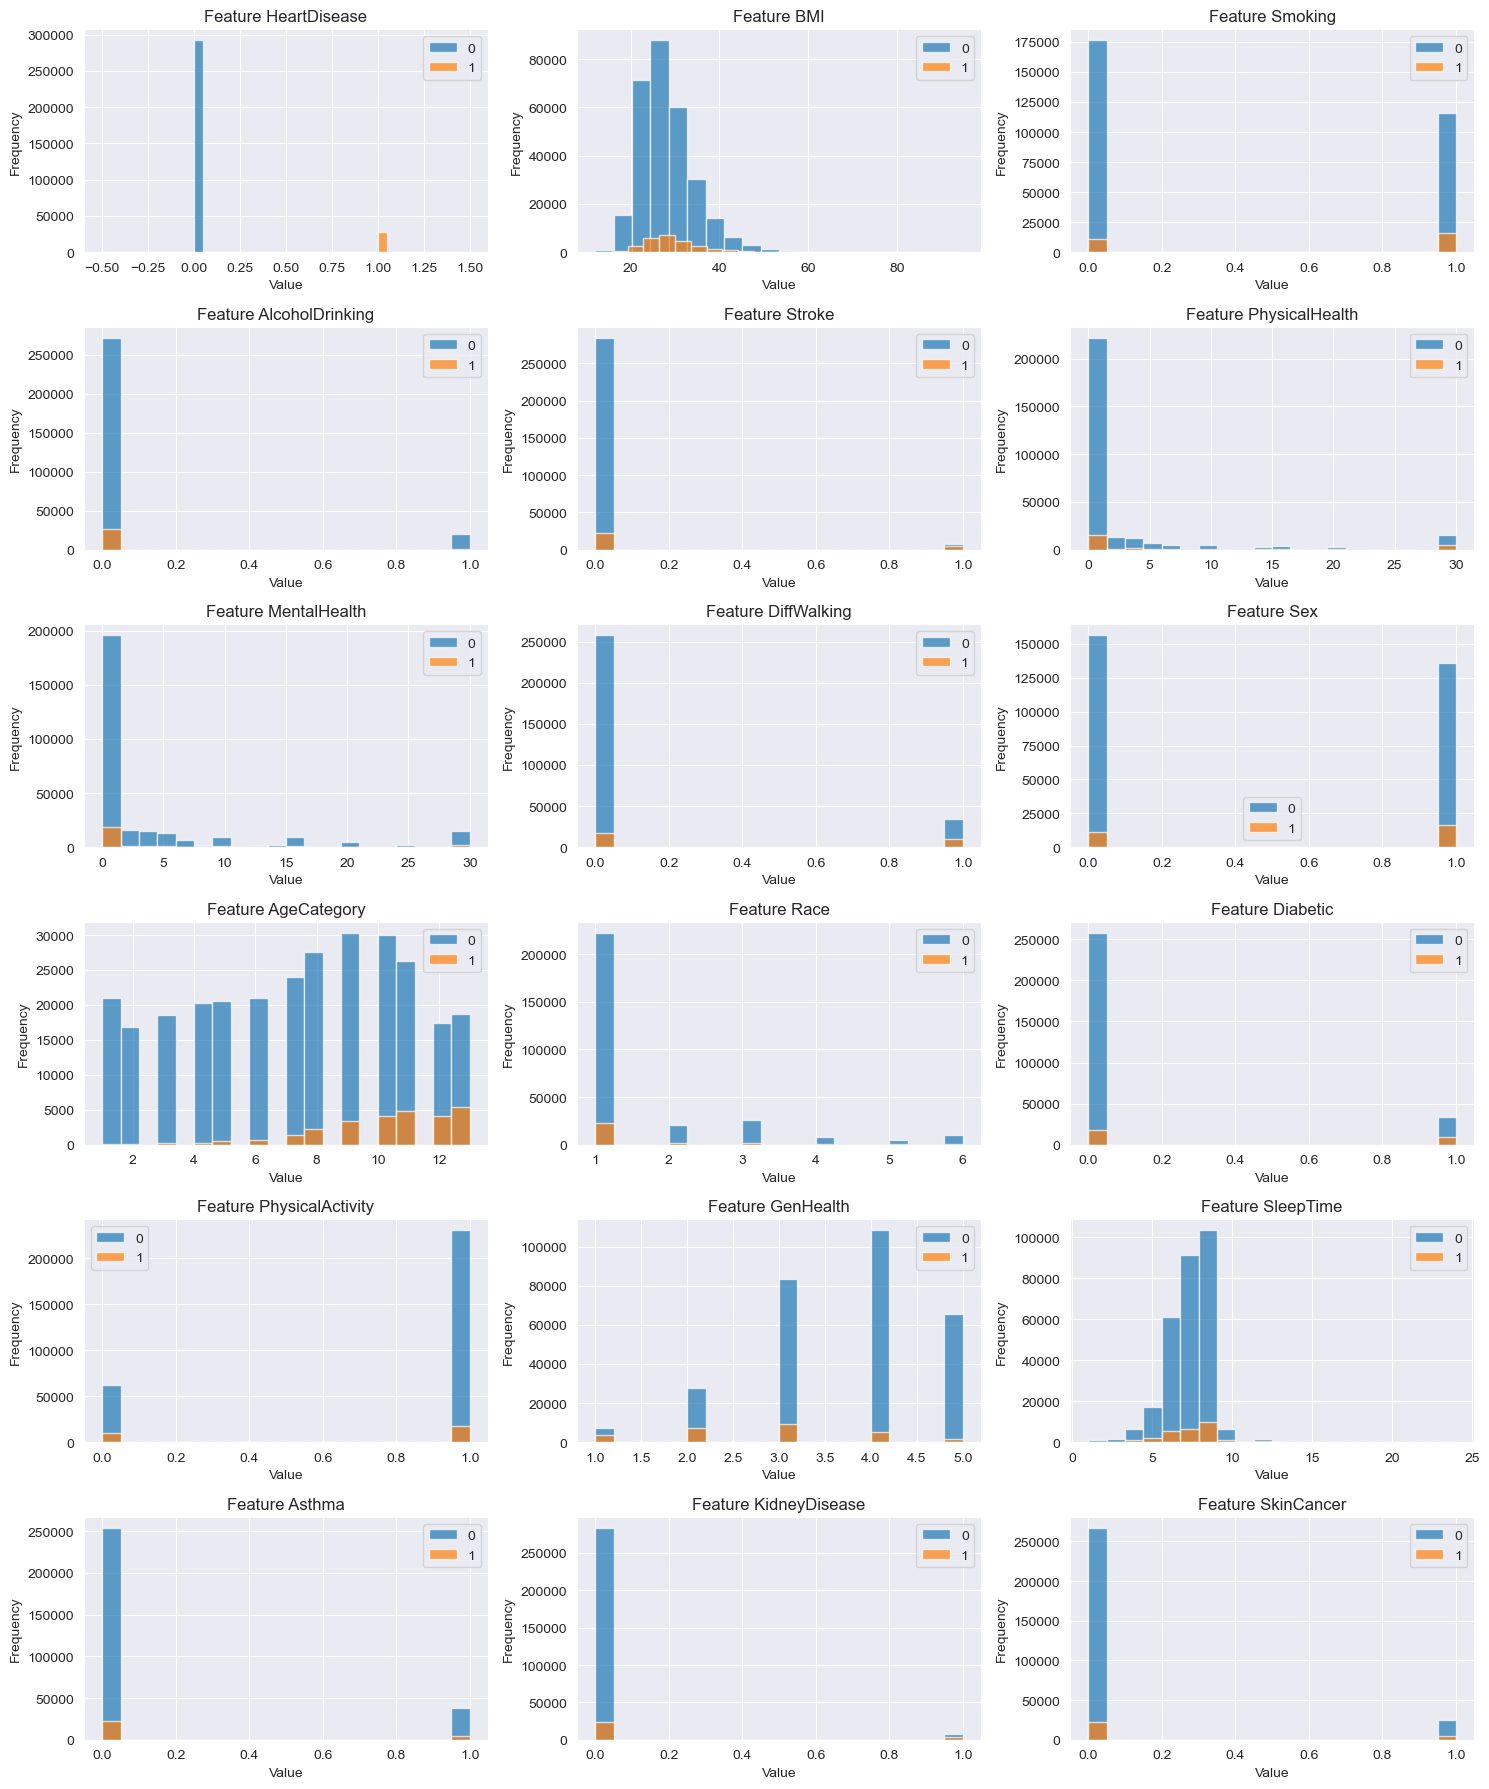

In [13]:
data_visualization = DataVisualization(data_loader, ['correlation', 'box', 'barh'])
data_visualization.plot_all_features()

# Outliers
During the examination of the plots, we detected outliers within the data, prompting a closer inspection of these influential data points.

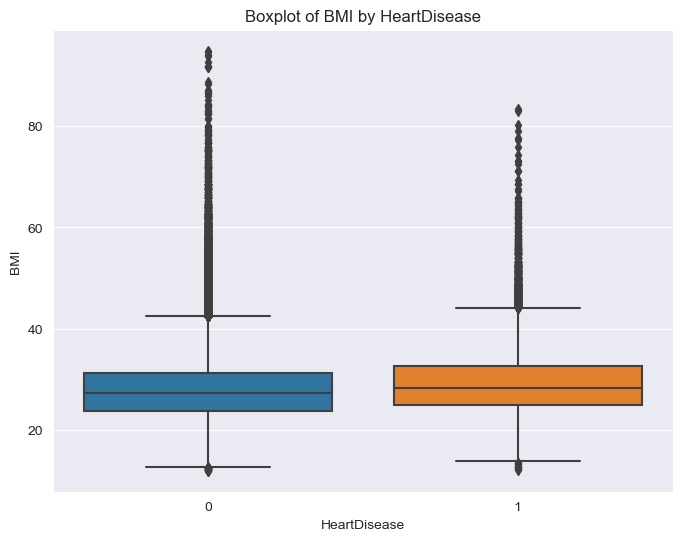

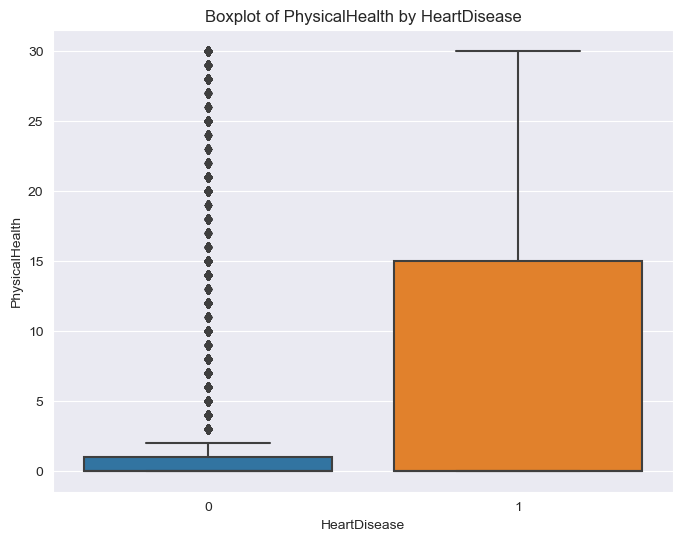

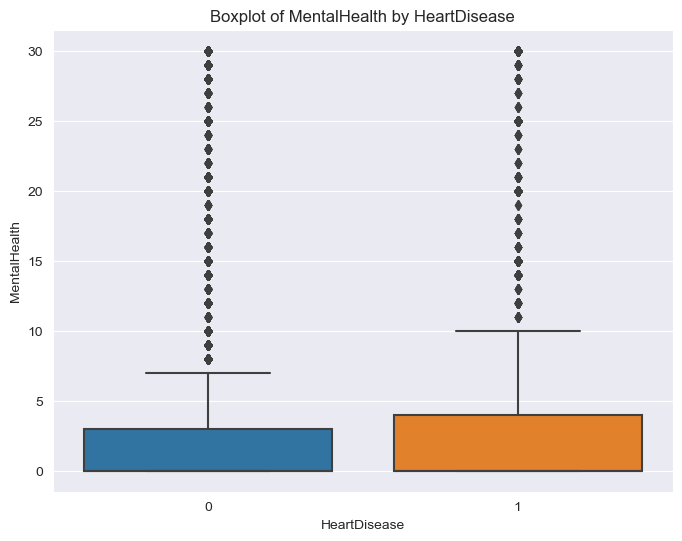

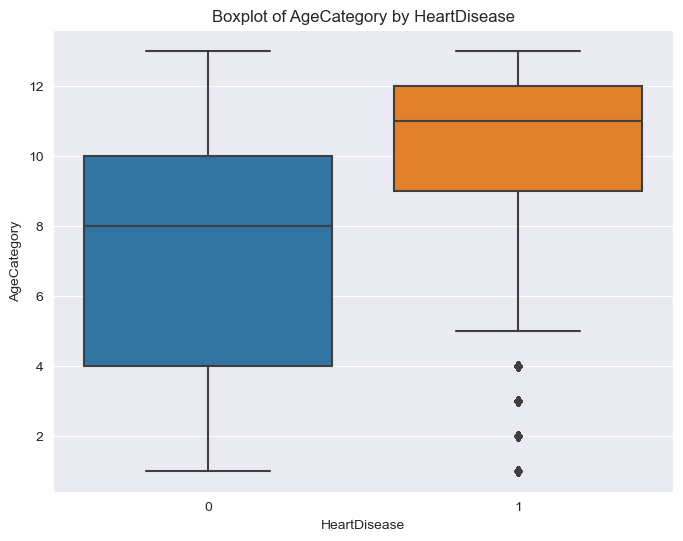

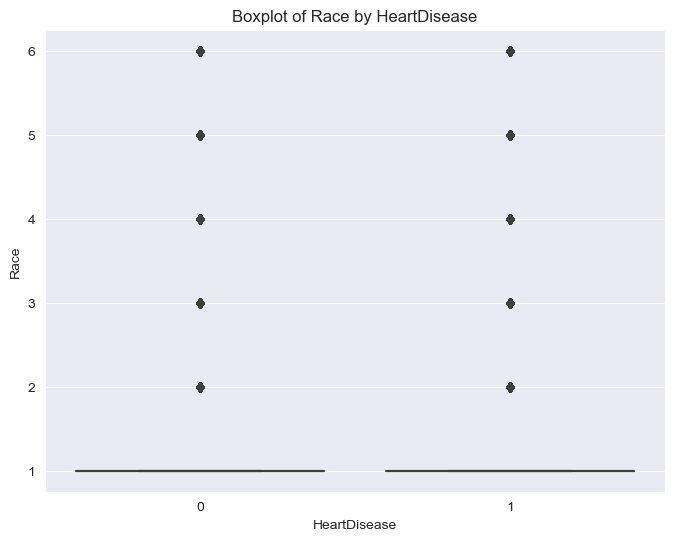

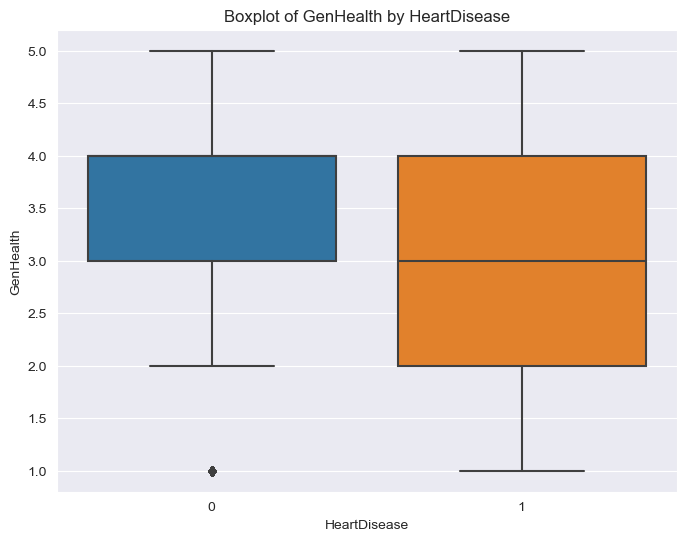

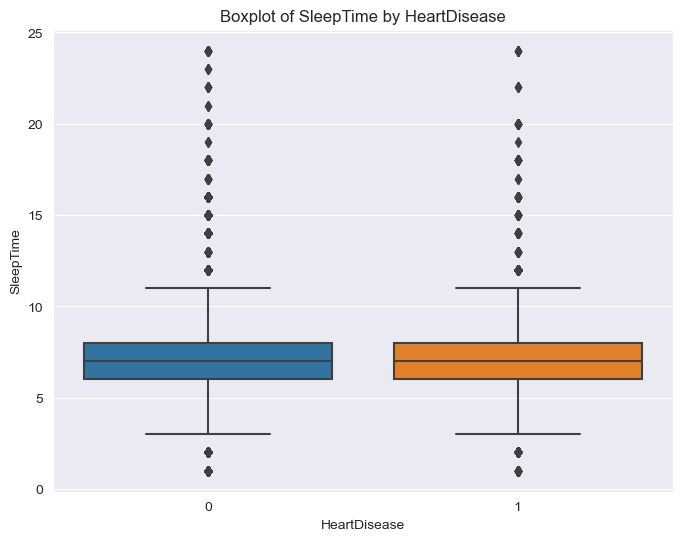

In [14]:
data_visualization.plots(['box'])

# Clean the data

Ensuring the reliability of datasets is paramount in data analysis. The DataCleaning class outlined below tackles this by addressing duplicate entries and outliers. Initial steps involved purging duplicates, followed by meticulous outlier identification and correction.


In [15]:
data_cleaner = DataCleaning(data_loader)
data_cleaner.handle_missing_values()
data_cleaner.remove_duplicates()
data_cleaner.detect_and_remove_outliers()


Original Dataset before cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  int32  
 10  Race              319795 non-null  int32  
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int32  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null

# Histograms after cleaning

Let's visualize the distribution of our features after cleaning dataset.


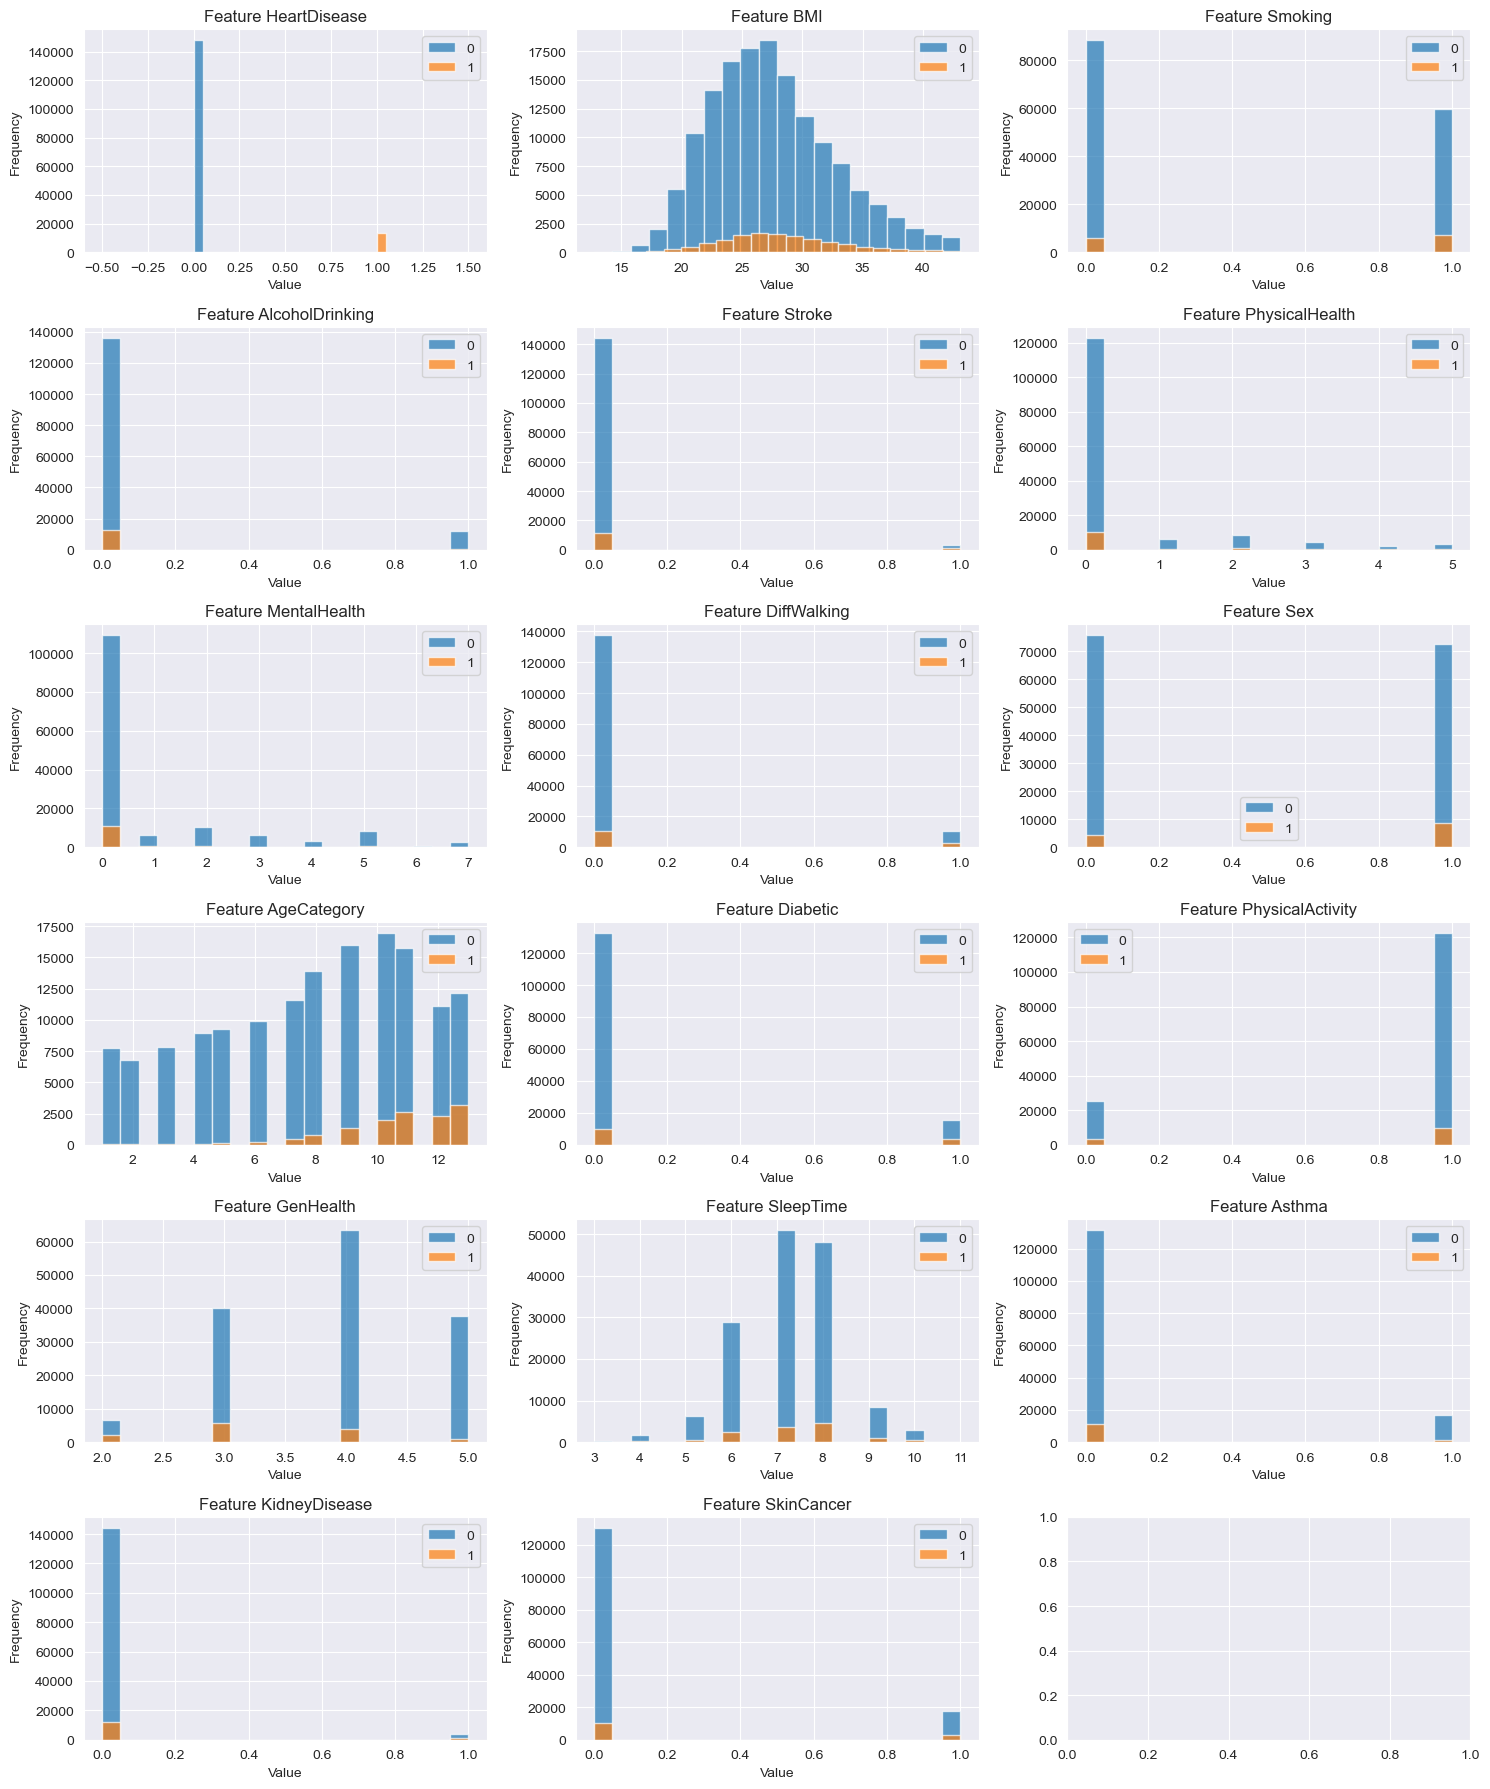

In [16]:
data_visualization.plot_all_features()

# Correlation and Permutation Importance
This heatmap visually represents the correlations between variables, with color gradients indicating the strength and direction of these relationships. In our specific analysis focused on HeartDisease, we assessed the correlations with various features. The correlation values, presented below, showcase the degree of association.
Following the heatmap analysis, we proceeded to perform a Permutation Importance analysis and visualized the results through a horizontal bar chart ('barh'). This approach allows us to delve deeper into the importance of each feature in predicting HeartDisease.

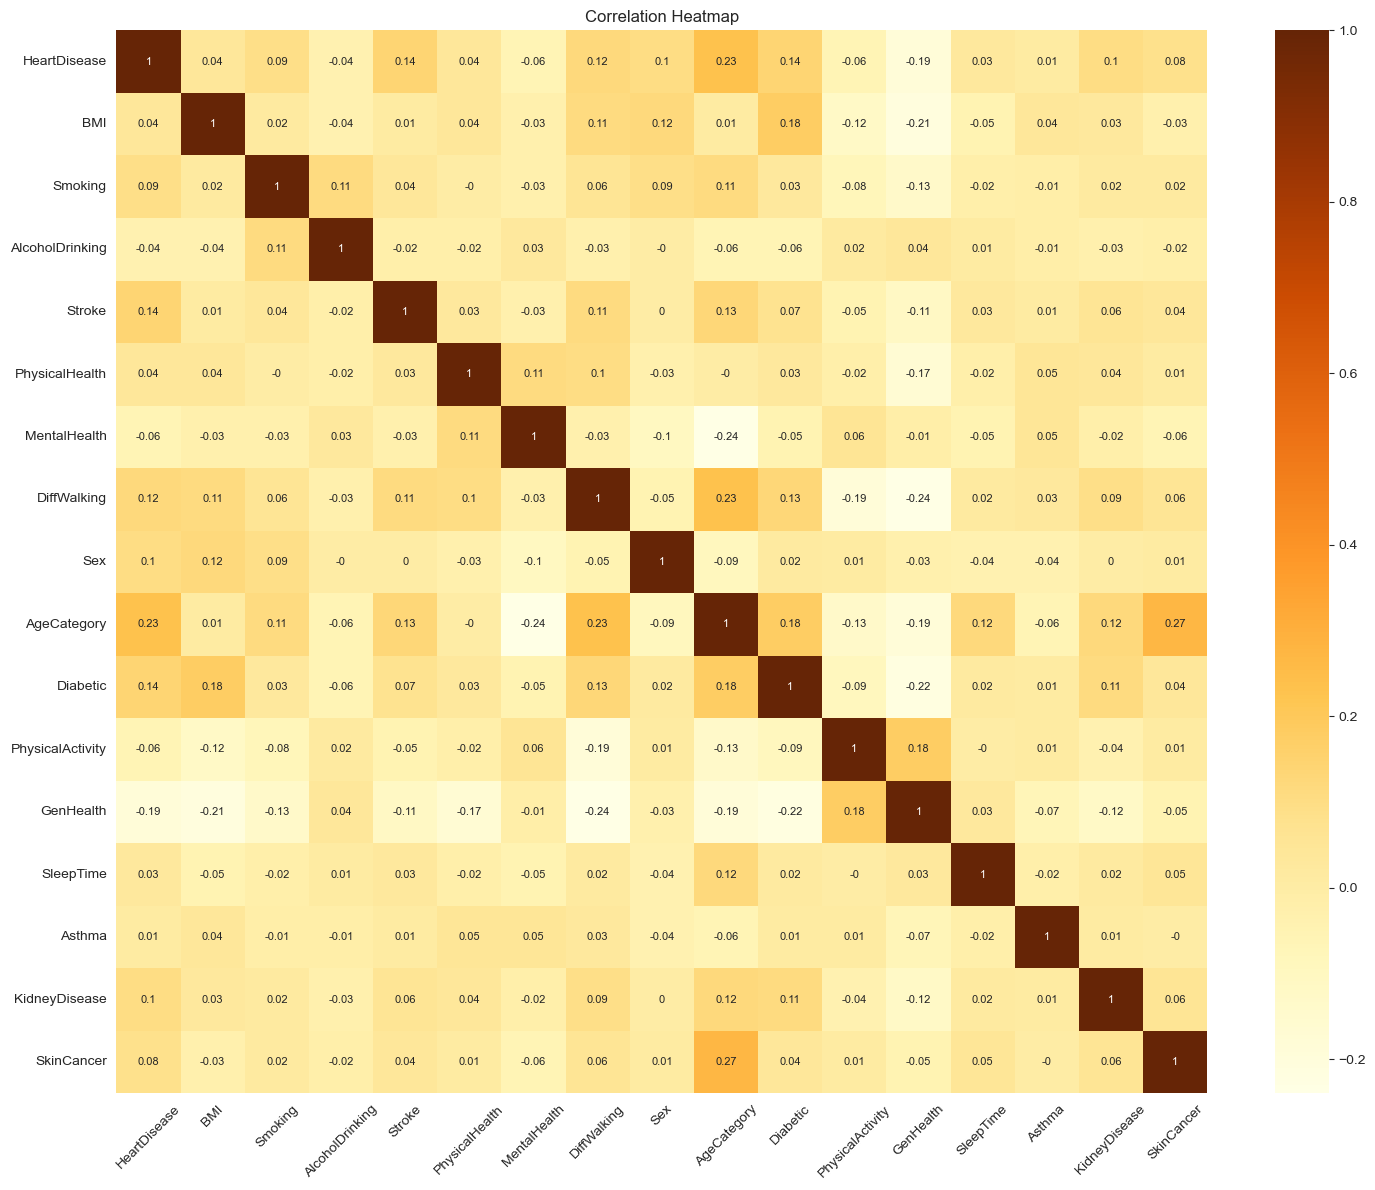


Correlation of the features with Heart Disease:

HeartDisease        1.00
AgeCategory         0.23
Diabetic            0.14
Stroke              0.14
DiffWalking         0.12
KidneyDisease       0.10
Sex                 0.10
Smoking             0.09
SkinCancer          0.08
BMI                 0.04
PhysicalHealth      0.04
SleepTime           0.03
Asthma              0.01
AlcoholDrinking    -0.04
MentalHealth       -0.06
PhysicalActivity   -0.06
GenHealth          -0.19
Name: HeartDisease, dtype: float64


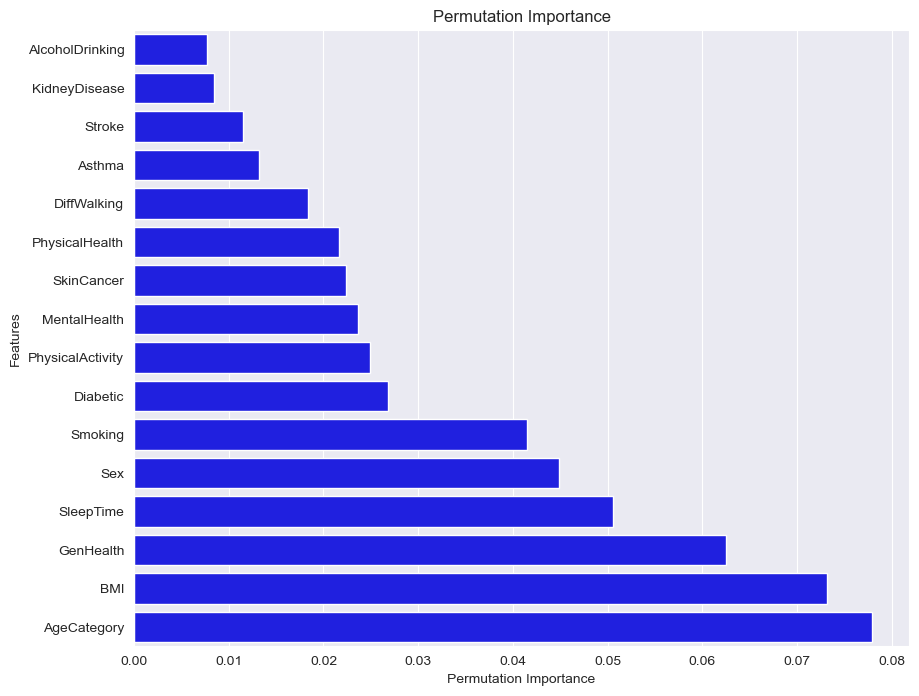

In [17]:
data_visualization.plots(['correlation', 'barh'])

# Dimensionality Reduction Selection

For our dataset, we opted for dimensionality reduction using UMAP and PCA. Through experimentation, these two methods consistently delivered the best results. UMAP excels in capturing intricate relationships, while PCA efficiently handles linear dimensionality reduction. Together, they provide a balanced approach to preserving essential data features in reduced dimensions.

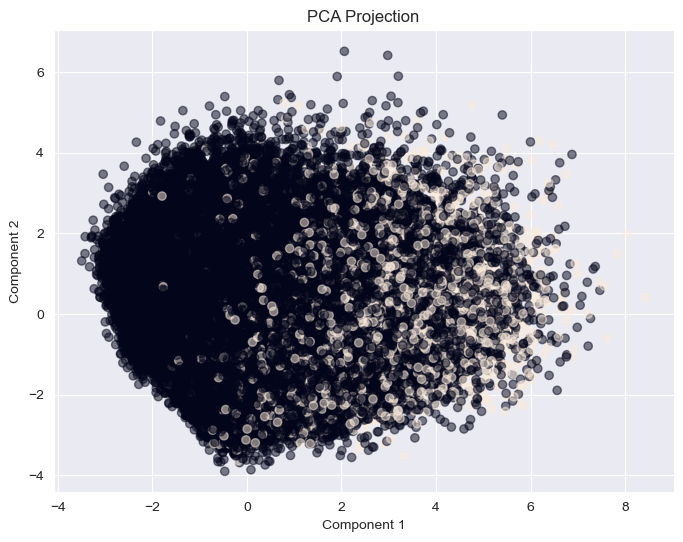

AttributeError: module 'umap' has no attribute 'UMAP'

In [18]:
dr = DimensionalityReduction(data_loader)
dr.plot_projection(dr.compute_pca(), 'PCA Projection')
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

# Hypothesis Testing

## Normality Test

Before delving into the exploration of feature importance, we first sought to understand the distributional characteristics of our data. To achieve this, we initially employed Shapiro-Wilk tests, aiming to assess the normality of our feature distributions.

However, the results from the Shapiro-Wilk tests yielded p-values that were remarkably close to zero or even zero itself. This indicates challenges in accepting the null hypothesis of normality for our dataset.


In [ ]:
tester = HypothesisTester(data_loader)
tester.test_normality()

## QQ plots
However, upon observing that the Shapiro-Wilk tests did not provide as much clarity as desired, we turned to a visual approach using QQ plots. By visually inspecting which plot, with points following the diagonal line, we identified that both `BMI_with_HD` and `BMI_without_HD` displayed distributional characteristics aligning with normality.

In [ ]:
tester.qq_plots()

## Hypothesis Testing techniques
To explore the distributional characteristics of our data, especially considering the unpaired nature of our dataset (where there is no before-and-after relationship for the same individual), we employed hypothesis testing techniques.

For normally distributed variables (as determined through visual inspection using QQ plots), we utilized the unpaired t-test. This statistical test helps us compare means between two independent groups. In our case, it was applied to features such as `BMI_with_HD`.

For non-normally distributed variables, the Wilcoxon rank-sum test was chosen. This non-parametric test is suitable for comparing medians between two independent groups. It was employed for features that did not exhibit normal distribution characteristics, like `Diabetic_without_HD`.


In [ ]:
tester.distribut_normality_data()
tester.perform_tests()

# Feature Creation
Informed by our exploration and hypothesis testing, we decided to create 10 new features that we believe hold significance for our investigation. These features were chosen based on their notable correlation with heart diseases, and we anticipate their utility in enhancing our predictive model. Below, you can find the names of these newly created features, along with the new histograms and a correlation heatmap for visual reference:


In [ ]:
feature_creator = FeatureCreation(data_loader)
feature_creator.create_modified_features()
feature_creator.create_joined_features()
feature_creator.create_interaction_features()

In [ ]:
data_visualization.plot_all_features()
data_visualization.plots(['correlation'])